# Trabajo Práctico 1

## 1. Entrenamiento de una red de Hopfield (1982)

### Carga y conversión de imágenes a formato binario

Se define un conjunto de funciones para cargar las imágenes `.bmp` desde una carpeta y convertirlas a matrices binarias de `0` y `1`, donde `1` representa píxeles blancos y `0` píxeles negros. Estas matrices representan los patrones que serán almacenados en la red de Hopfield.


In [61]:
from PIL import Image
import os
import numpy as np

def cargar_imagen_en_binario(ruta, invert=False):
    """
    Abre una imagen ya binaria (0 o 255), la convierte a {0,1}.
    - invert: True para 1=negro, False para 1=blanco
    Devuelve list[list[int]] para compatibilidad con tu pipeline actual.
    """
    img = Image.open(ruta).convert("L")  # escala de grises
    arr = np.array(img, dtype=np.uint8)  # (h, w) 0 o 255

    binaria = (arr > 0).astype(np.uint8)  # 1 si 255, 0 si 0
    if invert:
        binaria = 1 - binaria

    h, w = binaria.shape
    print(f"{os.path.basename(ruta)} - tamaño: {w}x{h}")
    return binaria.tolist()

def cargar_patrones_desde_carpeta(carpeta, invert=False):
    """
    Carga .bmp como patrones binarios {0,1}. Mantiene mismos prints y salida (listas).
    """
    archivos_bmp = sorted([f for f in os.listdir(carpeta) if f.lower().endswith(".bmp")])
    patrones = []
    for archivo in archivos_bmp:
        ruta_completa = os.path.join(carpeta, archivo)
        patron = cargar_imagen_en_binario(ruta_completa, invert=invert)
        patrones.append(patron)

    if patrones:
        print(f"Se cargaron {len(patrones)} patrones de {len(patrones[0])} filas y {len(patrones[0][0])} columnas cada uno.")
    else:
        print("No se encontraron archivos .bmp en la carpeta.")
    return patrones


### Vectorización y normalización de patrones

En esta etapa se toma cada imagen cargada como una matriz binaria (valores `0` y `1`) y se convierte en un vector unidimensional con valores `-1` y `1`. Esta transformación es necesaria porque la red de Hopfield representa cada patrón como un vector de activaciones, donde los valores deben estar centrados en torno al cero para cumplir con los fundamentos del modelo.

Primero, cada valor `0` se transforma en `-1`, y cada `1` se mantiene. Luego, la matriz bidimensional de la imagen se aplana en un solo vector, lo que permite operar con productos exteriores y aplicar dinámicas de red en forma vectorial.

Este paso asegura que los patrones estén en el formato correcto para entrenar la red y realizar recuperaciones.


In [62]:
import numpy as np

import numpy as np

def centrar_y_vectorizar_patrones(patrones, invert=False):
    """
    Convierte patrones binarios {0,1} (P,h,w) en vectores {-1,+1} (P,N), dtype=int8.
    - invert=True: 1 <-> 0 antes de mapear.
    """
    arr = np.asarray(patrones)
    if arr.size == 0:
        print("Tengo 0 patrones vectorizados de 0 elementos cada uno.")
        return arr.reshape(0, 0).astype(np.int8)

    if arr.ndim == 2:  # un solo patrón
        arr = arr[None, ...]

    if invert:
        arr = 1 - arr

    X = arr.reshape(arr.shape[0], -1)  # (P, N)
    Xpm1 = (X * 2 - 1).astype(np.int8)  # {0,1} -> {-1,+1}

    print(f"Tengo {Xpm1.shape[0]} patrones vectorizados de {Xpm1.shape[1]} elementos cada uno.")
    return Xpm1


carpeta_imagenes = "imagenes/50x50"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)
patrones_originales = patrones  # si te devuelve listas, no pasa nada
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones)  # -> np.ndarray (P, N) int8

print("Tengo " + str(len(patrones_vectorizados)) +
      " patrones vectorizados de " + str(len(patrones_vectorizados[0])) +
      " elementos cada uno.")

print(patrones_vectorizados)

panda.bmp - tamaño: 50x50
perro.bmp - tamaño: 50x50
v.bmp - tamaño: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.
Tengo 3 patrones vectorizados de 2500 elementos cada uno.
Tengo 3 patrones vectorizados de 2500 elementos cada uno.
[[ 1  1  1 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


### Inicialización de la matriz de pesos

Antes de entrenar la red de Hopfield, se debe crear la matriz de pesos sinápticos `W`, que define las conexiones entre neuronas. Esta matriz es cuadrada y tiene dimensiones `N × N`, donde `N` es la cantidad total de píxeles (o neuronas) por patrón.

Inicialmente, todos los pesos se establecen en cero, y luego se actualizarán mediante la regla de Hebb durante el entrenamiento. Esta matriz almacena el conocimiento aprendido por la red.


In [63]:

def inicializar_matriz_pesos(dimension, dtype=np.float32):
    """
    Inicializa una matriz cuadrada de pesos de tamaño NxN con ceros (NumPy).
    """
    return np.zeros((dimension, dimension), dtype=dtype)

ancho = 50
alto = 50
dimension = ancho * alto  # 2500

pesos = inicializar_matriz_pesos(dimension)
print(f"mis pesos tienen la dimensión: {len(pesos)}x{len(pesos[0])}")

mis pesos tienen la dimensión: 2500x2500


### Entrenamiento de la red de Hopfield

La red de Hopfield se entrena utilizando la **regla de Hebb**, una regla de aprendizaje no supervisado que refuerza las conexiones entre neuronas que se activan simultáneamente. En esta implementación, se recorren todos los patrones vectorizados y se calcula la **suma de los productos exteriores** de cada patrón consigo mismo.

El resultado es una matriz de pesos sinápticos que almacena la información de los patrones aprendidos. Finalmente, se eliminan las autoconexiones (valores en la diagonal) ya que una neurona no debe influenciarse a sí misma.

Esta matriz será utilizada para recuperar patrones a partir de entradas ruidosas o incompletas.


In [64]:
import numpy as np

def entrenar_red_hopfield(patrones_vectorizados, norm='N'):
    """
    Entrena Hopfield con patrones en {-1, +1} (acepta también {0,1} y los convierte).
    Retorna W (N, N) float32, diagonal = 0.
    
    norm: 'N' -> divide por N (clásico Hopfield)
          'P' -> divide por P (tu versión previa)
    """
    X = np.asarray(patrones_vectorizados)
    if X.ndim == 1:
        X = X[None, :]

    # Asegurar valores en {-1,+1}
    u = np.unique(X)
    uset = set(u.tolist())
    if uset.issubset({0, 1}):
        X = (X.astype(np.int16) * 2 - 1).astype(np.int8)
    elif not uset.issubset({-1, 1}):
        # fallback: >0 -> 1, else -1
        X = np.where(X > 0, 1, -1).astype(np.int8)

    X = X.astype(np.float32, copy=False)
    P, N = X.shape

    W = X.T @ X
    if norm == 'N':
        W /= float(N)
    elif norm == 'P':
        W /= float(P)
    else:
        raise ValueError("norm debe ser 'N' o 'P'.")

    np.fill_diagonal(W, 0.0)
    return W

# Uso igual que antes
pesos = entrenar_red_hopfield(patrones_vectorizados, norm='N')  # o 'P' para reproducir tu versión
print(f"Matriz de pesos entrenada con tamaño: {len(pesos)}x{len(pesos[0])}")


Matriz de pesos entrenada con tamaño: 2500x2500


In [65]:
def recuperar_patron(patron_inicial, pesos, max_iter=100, rng=None):
    """
    Recupera un patrón aplicando actualización asíncrona hasta converger.
    
    Parámetros
    ----------
    patron_inicial : array-like (N,)
        Estado inicial en {-1, +1}.
    pesos : np.ndarray (N, N)
        Matriz de pesos (float), idealmente con diagonal en 0.
    max_iter : int
        Máximo de barridos asíncronos completos.
    rng : np.random.Generator | None
        Generador para reproducibilidad. Si None, se crea uno por defecto.

    Retorna
    -------
    np.ndarray (N,) dtype=int8 en {-1, +1}
    """
    W = np.asarray(pesos)
    estado = np.asarray(patron_inicial, dtype=np.int8).copy()
    N = estado.size
    if rng is None:
        rng = np.random.default_rng()

    for _ in range(max_iter):
        cambios = 0
        for i in rng.permutation(N):              # orden aleatorio en cada barrido
            h = W[i].dot(estado)                  # campo local
            nuevo = 1 if h >= 0 else -1
            if estado[i] != nuevo:
                estado[i] = nuevo
                cambios += 1
        if cambios == 0:                          # convergió
            break

    return estado


In [66]:
import numpy as np
import matplotlib.pyplot as plt

def mostrar_comparacion_patron(original, recuperado, ancho, alto, indice=0):
    ori = np.asarray(original).reshape(alto, ancho)
    rec = np.asarray(recuperado).reshape(alto, ancho)

    # Si están en {-1,+1}, llevamos a {0,1} para visualizar
    if ori.min() < 0 or rec.min() < 0:
        ori_show = (ori + 1) / 2.0
        rec_show = (rec + 1) / 2.0
    else:
        ori_show, rec_show = ori, rec

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(ori_show, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title(f"Original {indice}")
    axs[0].axis('off')

    axs[1].imshow(rec_show, cmap='gray', vmin=0, vmax=1)
    axs[1].set_title(f"Recuperado {indice}")
    axs[1].axis('off')

    plt.suptitle(f"Comparación patrón {indice}")
    plt.tight_layout()
    plt.show()


### Evaluación de recuperación sin ruido

En este paso se verifica si la red de Hopfield es capaz de recuperar correctamente los patrones originales que fueron utilizados durante el entrenamiento. Para ello, cada patrón se usa como entrada inicial y se aplica la dinámica de la red hasta que converge a un estado estable.

Si el estado final es idéntico al patrón original, se considera que la recuperación fue exitosa. Esto demuestra que la red ha almacenado correctamente los patrones en su memoria asociativa.


El patrón 0 fue recuperado correctamente.


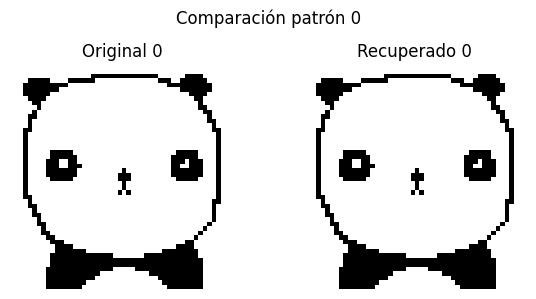

El patrón 1 fue recuperado correctamente.


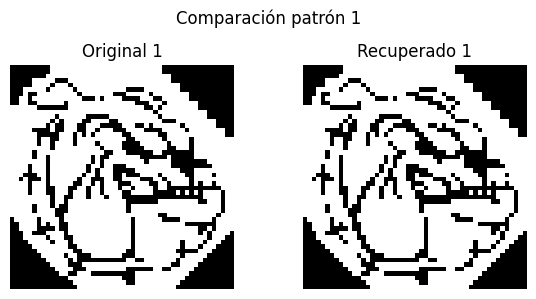

El patrón 2 fue recuperado correctamente.


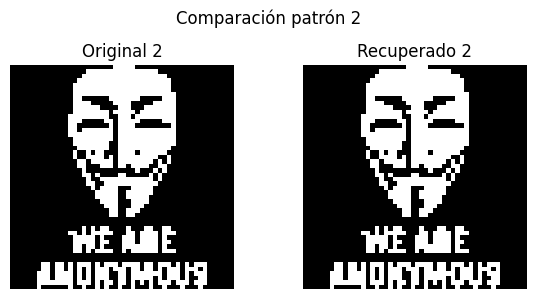

In [67]:
for i in range(len(patrones_vectorizados)):
   
    patron_original = patrones_vectorizados[i];
    # Recuperación asíncrona (usa tu versión NumPy de recuperar_patron)
    estado_convergido = recuperar_patron(patron_original, pesos, max_iter=10000)

    # Comparación correcta para arrays
    if np.array_equal(estado_convergido, patron_original):
        print(f"El patrón {i} fue recuperado correctamente.")
    else:
        print(f"El patrón {i} NO se recuperó correctamente.")

    # Visualización (la función ya soporta arrays)
    mostrar_comparacion_patron(patron_original, estado_convergido, ancho=50, alto=50, indice=i)


### Prueba con imágenes de 60x45

Se repite el procedimiento anterior utilizando un nuevo conjunto de imágenes de tamaño `60x45`. Se cargan, vectorizan y entrenan en la red de Hopfield. Luego, se verifica si la red es capaz de recuperar correctamente los patrones a partir de sí mismos.

Cada comparación muestra el patrón original y su versión recuperada tras aplicar la dinámica de la red. Esto permite verificar que el modelo puede escalar y seguir funcionando correctamente con imágenes más grandes.


paloma.bmp - tamaño: 60x45
quijote.bmp - tamaño: 60x45
torero.bmp - tamaño: 60x45
Se cargaron 3 patrones de 45 filas y 60 columnas cada uno.
Tengo 3 patrones vectorizados de 2700 elementos cada uno.
El patrón 0 fue recuperado correctamente.


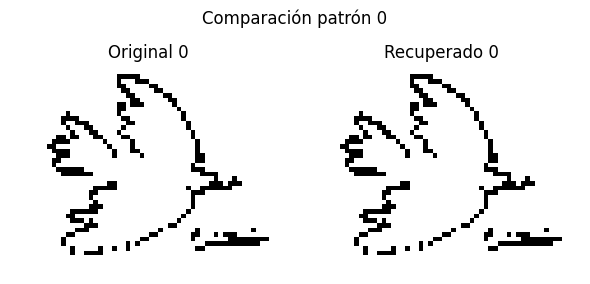

El patrón 1 fue recuperado correctamente.


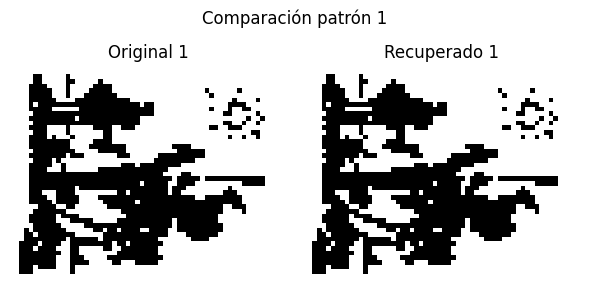

El patrón 2 fue recuperado correctamente.


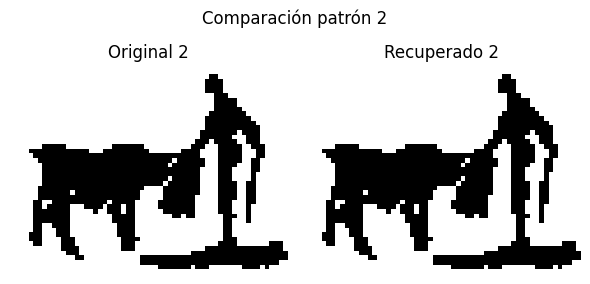

In [68]:
carpeta_imagenes = "imagenes/60x45"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)  # puede devolver listas; no hay problema
patrones_vectorizados_imagenes_grandes = centrar_y_vectorizar_patrones(patrones)  # -> np.ndarray (P, N) en {-1,+1}

ancho = 60
alto = 45
dimension = ancho * alto  # 2700

# Entrenamiento (no hace falta inicializar ceros antes)
pesos_imagenes_grandes = entrenar_red_hopfield(patrones_vectorizados_imagenes_grandes, norm='N')

for i in range(patrones_vectorizados_imagenes_grandes.shape[0]):
    patron_original = patrones_vectorizados_imagenes_grandes[i]                  # (N,)
    estado_convergido = recuperar_patron(patron_original, pesos_imagenes_grandes, max_iter=10000)

    if np.array_equal(estado_convergido, patron_original):
        print(f"El patrón {i} fue recuperado correctamente.")
    else:
        print(f"El patrón {i} NO se recuperó correctamente.")

    mostrar_comparacion_patron(patron_original, estado_convergido, ancho=ancho, alto=alto, indice=i)


### Conclusión: entrenamiento con 3 imágenes

Se entrenó la red de Hopfield con un conjunto reducido de 3 imágenes binarias. La red logró recuperar todos los patrones correctamente, lo que demuestra que, con un número limitado de patrones bien diferenciados, el modelo puede almacenar y recordar eficazmente la información sin interferencia.


### Agregado de ruido a los patrones

Para evaluar la robustez de la red de Hopfield, se introduce ruido artificial en los patrones antes de presentarlos a la red. La función `agregar_ruido` invierte aleatoriamente un porcentaje de los bits del patrón original (valores `-1` o `1`).

Este proceso simula entradas incompletas o corruptas, y permite comprobar si la red es capaz de recuperar el patrón correcto a pesar del ruido. La proporción de bits alterados se controla mediante el parámetro `porcentaje_ruido`, que puede variar entre `0.0` (sin ruido) y `1.0` (ruido total).


In [69]:
def agregar_ruido(patron, porcentaje_ruido, rng=None):
    """
    Invierte exactamente floor(n * porcentaje_ruido) bits de un patrón en {-1,+1}.
    - patron: array-like (N,) o (h,w)
    - porcentaje_ruido: 0..1
    - rng: np.random.Generator opcional para reproducibilidad
    Devuelve: np.ndarray misma forma y dtype=int8
    """
    x = np.asarray(patron)
    shape = x.shape
    x = x.astype(np.int8, copy=True).ravel()       # copia para no modificar el original

    n = x.size
    k = int(n * float(porcentaje_ruido))
    if k <= 0:
        return x.reshape(shape)

    rng = rng or np.random.default_rng()
    idx = rng.choice(n, size=k, replace=False)     # elige k posiciones únicas
    x[idx] *= -1                                   # invierte en bloque (vectorizado)
    return x.reshape(shape)


In [70]:
def contar_diferencias(p1, p2):
    """
    Cuenta cuántos bits difieren entre dos patrones del mismo tamaño.
    Acepta listas o ndarrays; soporta 1D o 2D (p.ej. h×w).
    """
    a = np.asarray(p1)
    b = np.asarray(p2)
    if a.shape != b.shape:
        raise ValueError(f"Formas distintas: {a.shape} vs {b.shape}")
    return int(np.count_nonzero(a != b))


### Evaluación de la tolerancia al ruido

En esta sección se analiza la capacidad de la red de Hopfield para recuperar correctamente los patrones originales a medida que se introduce ruido. Para ello, se prueba con distintos niveles de ruido (de 0% a 100%) invirtiendo aleatoriamente un porcentaje de los bits en cada patrón.

Se calcula el error promedio de recuperación (proporción de bits incorrectos) para cada nivel de ruido. Finalmente, se grafica la precisión de la red como función del ruido, lo cual permite visualizar su comportamiento frente a distorsiones crecientes.

Un buen modelo debería mantener alta precisión para bajos niveles de ruido, degradándose progresivamente a medida que la distorsión aumenta.


In [71]:
import numpy as np
import matplotlib.pyplot as plt

def evaluar_robustez_ruido(patrones_vectorizados, pesos, niveles_ruido=None,
                           max_iter=10000, modo_ruido='exact', rng=None):
    """
    Evalúa el desempeño de la red de Hopfield ante distintos niveles de ruido.

    Parámetros
    ----------
    patrones_vectorizados : (P,N) array-like en {-1,+1} (o convertible)
    pesos : (N,N) np.ndarray
    niveles_ruido : iterable de floats en [0,1]; por defecto [0.0, 0.1, ..., 1.0]
    max_iter : int, iteraciones para la convergencia (recuperación asíncrona)
    modo_ruido : 'exact' (invierte exactamente floor(p*N) bits por patrón) 
                 'bernoulli' (cada bit se invierte con probabilidad p; más rápido)
    rng : np.random.Generator para reproducibilidad

    Retorna
    -------
    niveles_ruido (list[float]), errores_promedio (list[float])
    """
    if niveles_ruido is None:
        niveles_ruido = [i / 10 for i in range(11)]  # 0.0 ... 1.0

    X = np.asarray(patrones_vectorizados)
    if X.ndim == 1:
        X = X[None, :]
    # Asegurar formato {-1,+1}
    U = set(np.unique(X).tolist())
    if U.issubset({0, 1}):
        X = (X.astype(np.int16)*2 - 1).astype(np.int8)
    elif not U.issubset({-1, 1}):
        X = np.where(X > 0, 1, -1).astype(np.int8)

    P, N = X.shape
    errores_promedio = []
    rng = rng or np.random.default_rng()

    for ruido in niveles_ruido:
        total_errores = 0

        if modo_ruido == 'bernoulli':
            # Aplico ruido por máscara para todos los patrones a la vez (rápido)
            mask = rng.random(size=(P, N)) < float(ruido)
            X_ruidoso = X.copy()
            X_ruidoso[mask] *= -1

            # Recupero patrón por patrón (la recuperación asíncrona es por vector)
            for p in range(P):
                estado_convergido = recuperar_patron(X_ruidoso[p], pesos, max_iter=max_iter)
                total_errores += int(np.count_nonzero(estado_convergido != X[p]))

        else:  # 'exact' — mismo comportamiento que tu agregar_ruido (exactamente k flips)
            for p in range(P):
                x_noisy = agregar_ruido(X[p], ruido, rng=rng)  # usa tu versión NumPy de agregar_ruido
                estado_convergido = recuperar_patron(x_noisy, pesos, max_iter=max_iter)
                total_errores += int(np.count_nonzero(estado_convergido != X[p]))

        promedio = total_errores / (P * N)
        errores_promedio.append(promedio)
        print(f"Ruido {int(ruido*100)}% → Error promedio: {promedio:.4f}")

    return niveles_ruido, errores_promedio


def graficar_precision_vs_ruido(niveles_ruido, errores_promedio):
    """
    Grafica la precisión de recuperación en función del nivel de ruido.
    precisión = 1 - error_promedio
    """
    niveles_ruido = list(niveles_ruido)
    errores_promedio = list(errores_promedio)
    precisiones = [1 - e for e in errores_promedio]

    plt.figure(figsize=(8, 4))
    plt.plot([r * 100 for r in niveles_ruido], precisiones, marker='o', linestyle='-')
    plt.title("Precisión de recuperación vs. nivel de ruido")
    plt.xlabel("Porcentaje de ruido (%)")
    plt.ylabel("Precisión de recuperación")
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3)
    plt.show()


# Imaganes 50x50

Ruido 0% → Error promedio: 0.0000
Ruido 10% → Error promedio: 0.0000
Ruido 20% → Error promedio: 0.0000
Ruido 30% → Error promedio: 0.0000
Ruido 40% → Error promedio: 0.0000
Ruido 50% → Error promedio: 0.5712
Ruido 60% → Error promedio: 1.0000
Ruido 70% → Error promedio: 1.0000
Ruido 80% → Error promedio: 1.0000
Ruido 90% → Error promedio: 1.0000
Ruido 100% → Error promedio: 1.0000


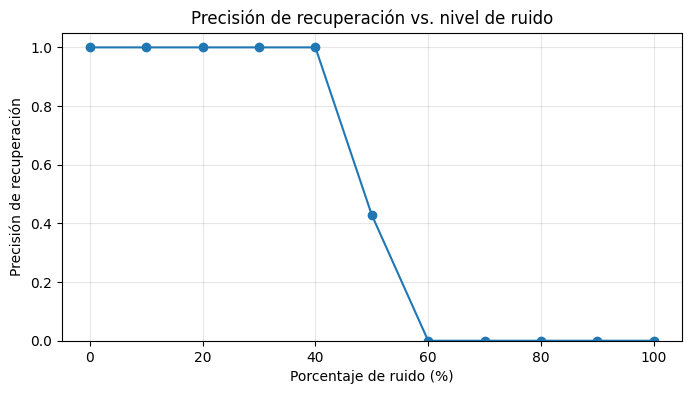

In [72]:
niveles, errores = evaluar_robustez_ruido(patrones_vectorizados, pesos)
graficar_precision_vs_ruido(niveles, errores)


# Imagenes 60x45

Ruido 0% → Error promedio: 0.0000
Ruido 10% → Error promedio: 0.0000
Ruido 20% → Error promedio: 0.0000
Ruido 30% → Error promedio: 0.0000
Ruido 40% → Error promedio: 0.0000
Ruido 50% → Error promedio: 0.6167
Ruido 60% → Error promedio: 1.0000
Ruido 70% → Error promedio: 1.0000
Ruido 80% → Error promedio: 1.0000
Ruido 90% → Error promedio: 1.0000
Ruido 100% → Error promedio: 1.0000


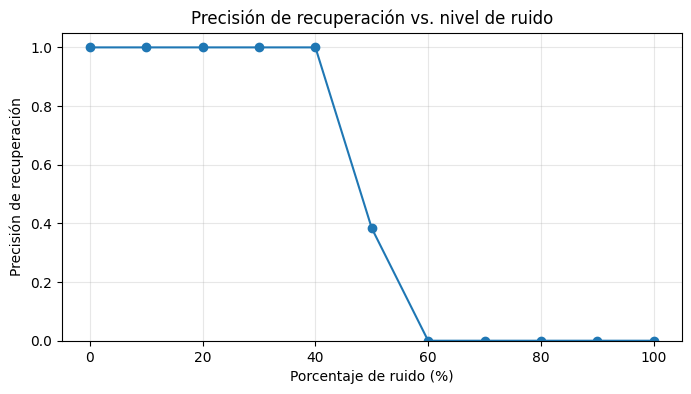

In [73]:
niveles, errores = evaluar_robustez_ruido(patrones_vectorizados_imagenes_grandes, pesos_imagenes_grandes)
graficar_precision_vs_ruido(niveles, errores)


# Punto 3

### Evaluación de estados espurios

En esta celda se prueba la existencia de **estados espurios** en la red de Hopfield entrenada:

- **Patrones invertidos**: se invierte el signo de todos los bits de cada patrón entrenado y se comprueba si el estado permanece estable.
- **Combinaciones impares**: se evalúa la estabilidad del estado resultante de aplicar `sign(P0 + P1 + P2)`.

Si estos estados convergen a sí mismos al ser presentados como entrada a la red, se considera que son **estados espurios estables**. Esta es una propiedad conocida de las redes de Hopfield, especialmente cuando se usan múltiples patrones y hay solapamiento entre ellos.


Por último, se evalúa la existencia de estados espurios del tipo **spin-glass**, que son mínimos locales de la energía que **no se parecen a ningún patrón almacenado** ni a combinaciones de ellos.

Para esto, se generan vectores aleatorios de activación (`-1` y `1`) que actúan como entradas completamente nuevas. Si la red converge a esos mismos estados sin haberlos aprendido, se considera que son **estados espurios del tipo spin-glass**.

Este fenómeno se vuelve más probable a medida que se entrena la red con un mayor número de patrones, lo cual genera interferencias y reduce la capacidad efectiva de almacenamiento.

paloma.bmp - tamaño: 60x45
quijote.bmp - tamaño: 60x45
torero.bmp - tamaño: 60x45
Se cargaron 3 patrones de 45 filas y 60 columnas cada uno.
Tengo 3 patrones vectorizados de 2700 elementos cada uno.

--- Estados inversos ---
Inverso del patrón 0 es un estado espurio estable.


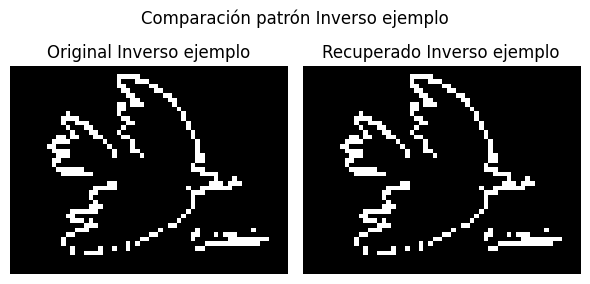

Inverso del patrón 1 es un estado espurio estable.


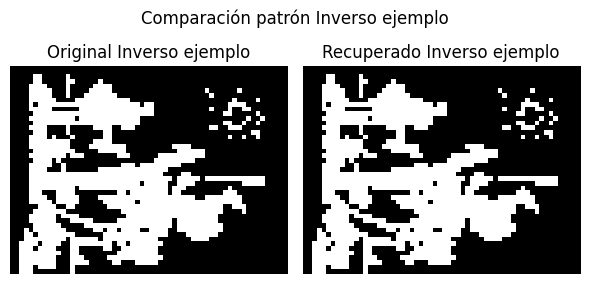

Inverso del patrón 2 es un estado espurio estable.


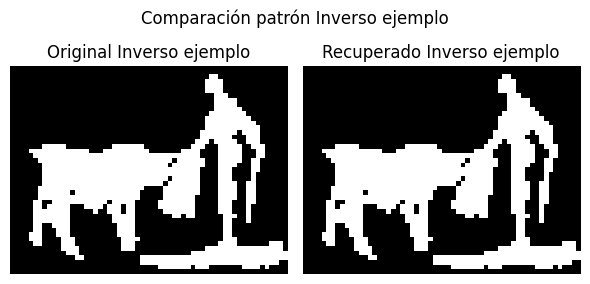


--- Combinación impar de 3 patrones: todas las ± ---
Combinación +P0 +P1 +P2: ESPURIO


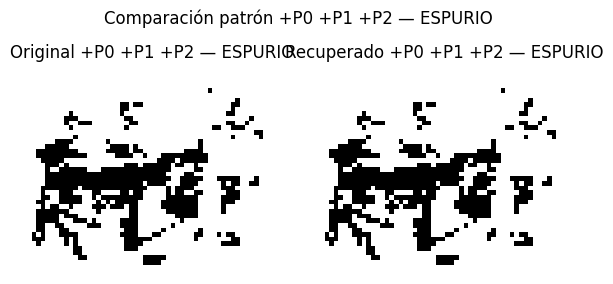

Combinación +P0 +P1 -P2: ESPURIO


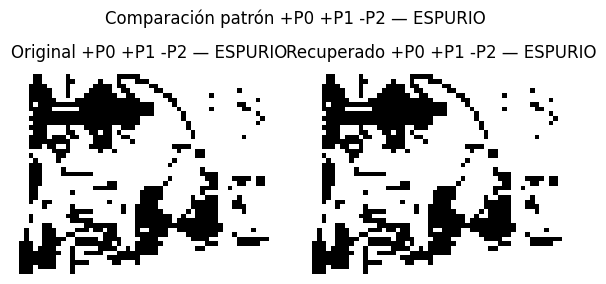

Combinación +P0 -P1 +P2: ESPURIO


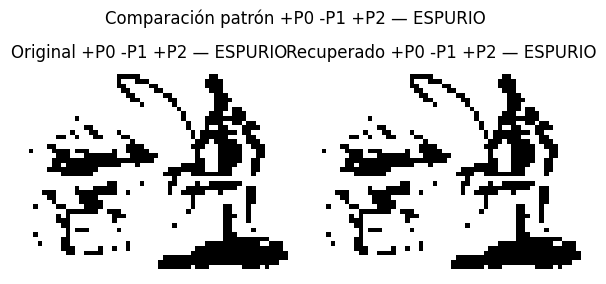

Combinación +P0 -P1 -P2: ESPURIO


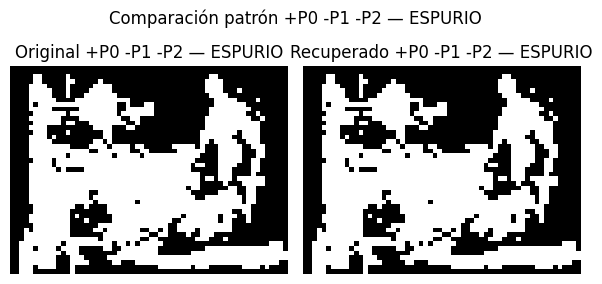

Combinación -P0 +P1 +P2: ESPURIO


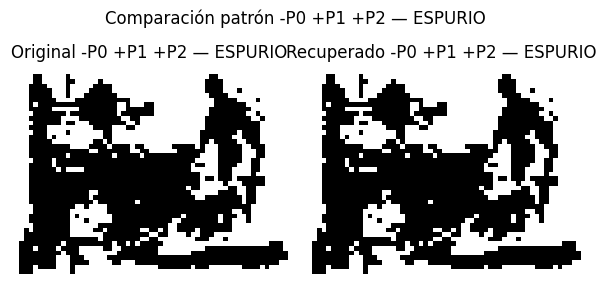

Combinación -P0 +P1 -P2: ESPURIO


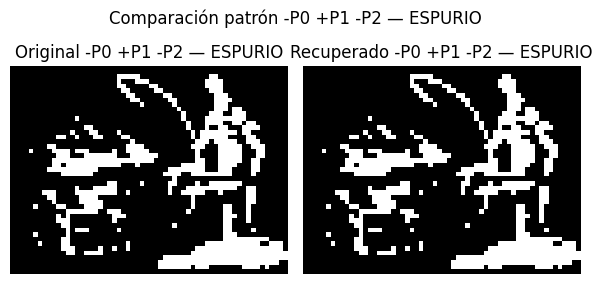

Combinación -P0 -P1 +P2: ESPURIO


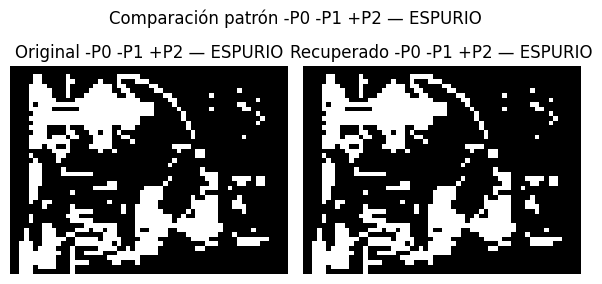

Combinación -P0 -P1 -P2: ESPURIO


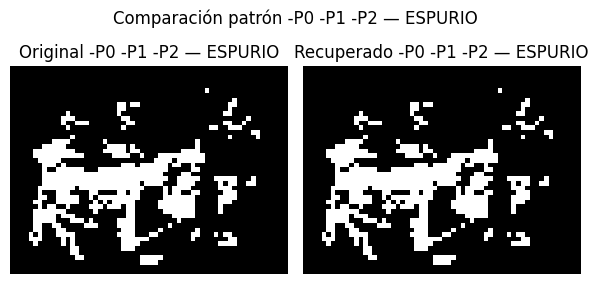

In [74]:
carpeta_imagenes = "imagenes/60x45"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)              # puede ser list; no pasa nada
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones)         # -> np.ndarray (P, N) en {-1,+1}

ancho, alto = 60, 45
dimension = ancho * alto

# Entrenar la red (vectorizado)
pesos = entrenar_red_hopfield(patrones_vectorizados)                    # W: (N, N)

# ---------- ESTADOS ESPURIOS ----------

def es_estable(estado, pesos, max_iter=10000):
    """
    Verifica si un estado es un mínimo estable (converge a sí mismo).
    """
    estado = np.asarray(estado, dtype=np.int8).ravel()
    convergido = recuperar_patron(estado, pesos, max_iter=max_iter)
    return np.array_equal(convergido, estado)

# 1) Inversos de cada patrón
print("\n--- Estados inversos ---")
for i in range(patrones_vectorizados.shape[0]):
    patron = patrones_vectorizados[i]
    inverso = (-patron).astype(np.int8, copy=False)
    if es_estable(inverso, pesos):
        print(f"Inverso del patrón {i} es un estado espurio estable.")
    else:
        print(f"Inverso del patrón {i} NO es estable.")
    rec_inv = recuperar_patron(inverso, pesos, max_iter=10000)
    mostrar_comparacion_patron(inverso, rec_inv, ancho, alto, indice="Inverso ejemplo")

# 2) Combinación impar de 3 patrones: TODAS las ± (sign(P0 ± P1 ± P2))
print("\n--- Combinación impar de 3 patrones: todas las ± ---")

if patrones_vectorizados.shape[0] >= 3:
    # Elegí los 3 que quieras (acá uso 0,1,2)
    i0, i1, i2 = 0, 1, 2
    P0 = patrones_vectorizados[i0]
    P1 = patrones_vectorizados[i1]
    P2 = patrones_vectorizados[i2]

    # Todas las combinaciones de signos (orden: +++, ++-, +-+, +--, -++, -+-, --+, ---)
    S = np.array([
        [ +1, +1, +1],
        [ +1, +1, -1],
        [ +1, -1, +1],
        [ +1, -1, -1],
        [ -1, +1, +1],
        [ -1, +1, -1],
        [ -1, -1, +1],
        [ -1, -1, -1],
    ], dtype=np.int8)

    def etiqueta_signos(row):
        return " ".join([
            ("+P0" if row[0] == 1 else "-P0"),
            ("+P1" if row[1] == 1 else "-P1"),
            ("+P2" if row[2] == 1 else "-P2"),
        ])

    # Apilar y combinar: comb = sign(S @ [P0;P1;P2])
    P_stack = np.stack([P0, P1, P2], axis=0).astype(np.int16)   # (3, N) int16 para evitar overflow
    comb_sum = S @ P_stack                                      # (8, N)
    combos = np.where(comb_sum >= 0, 1, -1).astype(np.int8)     # regla: >=0 -> +1

    # Evaluar estabilidad y MOSTRAR TODAS las combinaciones
    for row, estado in zip(S, combos):
        rec = recuperar_patron(estado, pesos, max_iter=10000)
        estable = np.array_equal(rec, estado)
        print(f"Combinación {etiqueta_signos(row)}: {'ESPURIO' if estable else 'NO estable'}")
        # Mostrar lado a lado (init vs recuperado)
        mostrar_comparacion_patron(
            estado, rec, ancho, alto,
            indice=f"{etiqueta_signos(row)} — {'ESPURIO' if estable else 'NO estable'}"
        )
else:
    print("No hay suficientes patrones para probar combinación impar.")


panda.bmp - tamaño: 50x50
perro.bmp - tamaño: 50x50
v.bmp - tamaño: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.
Tengo 3 patrones vectorizados de 2500 elementos cada uno.

--- Estados inversos ---
Inverso del patrón 0 es un estado espurio estable.


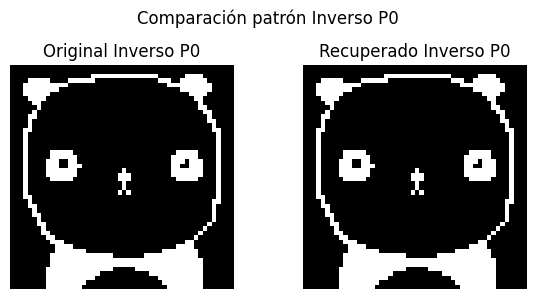

Inverso del patrón 1 es un estado espurio estable.


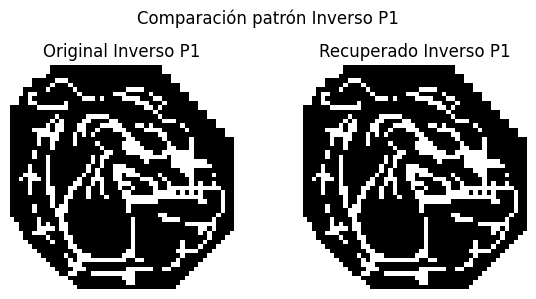

Inverso del patrón 2 es un estado espurio estable.


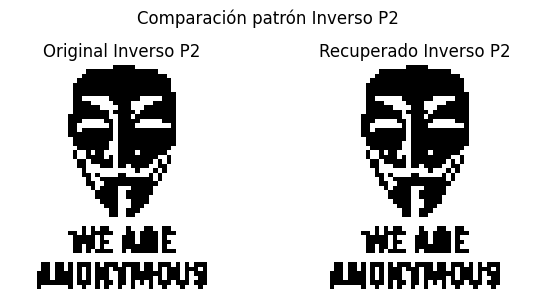


--- Combinación impar de 3 patrones: todas las ± ---
Combinación +P0 +P1 +P2: ESPURIO


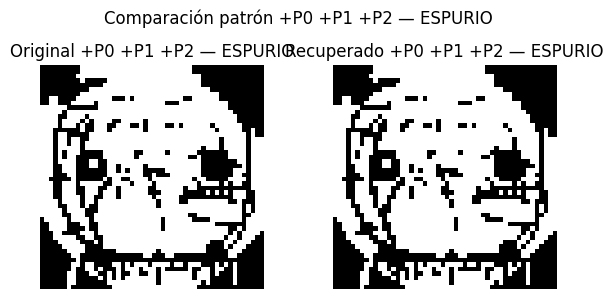

Combinación +P0 +P1 -P2: ESPURIO


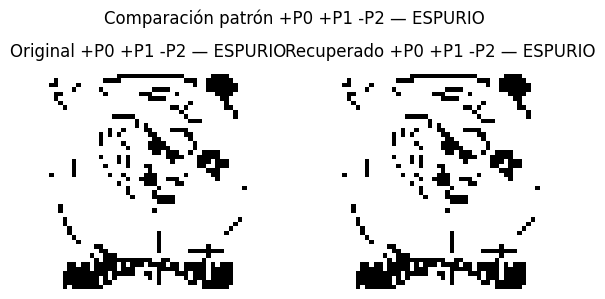

Combinación +P0 -P1 +P2: ESPURIO


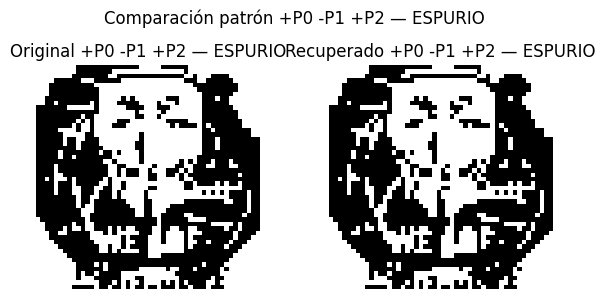

Combinación +P0 -P1 -P2: ESPURIO


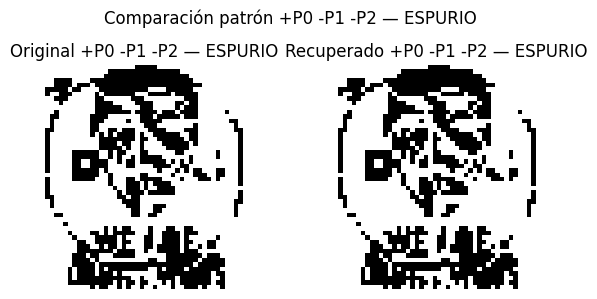

Combinación -P0 +P1 +P2: ESPURIO


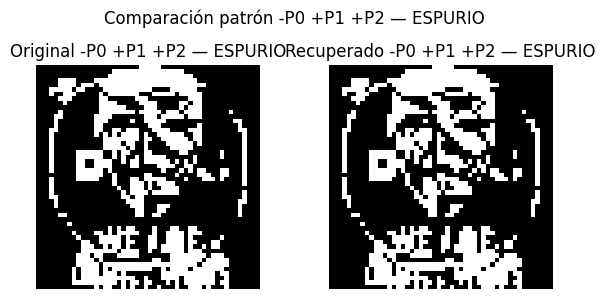

Combinación -P0 +P1 -P2: ESPURIO


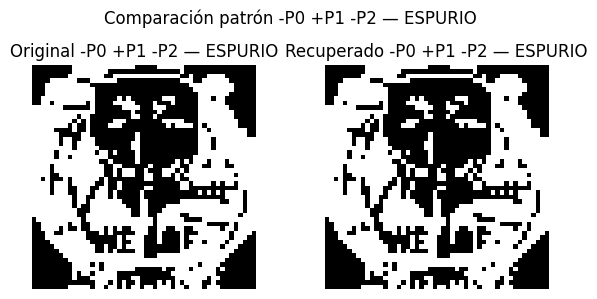

Combinación -P0 -P1 +P2: ESPURIO


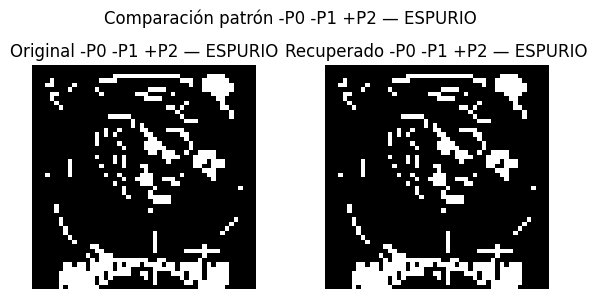

Combinación -P0 -P1 -P2: ESPURIO


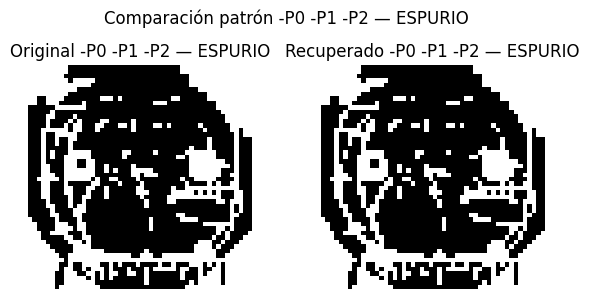


--- Estados tipo spin-glass ---
Estado aleatorio 0 NO es estable.
Estado aleatorio 1 NO es estable.
Estado aleatorio 2 NO es estable.
Estado aleatorio 3 NO es estable.
Estado aleatorio 4 NO es estable.


In [75]:
carpeta_imagenes = "imagenes/50x50"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)              # puede ser list; ok
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones)         # -> np.ndarray (P, N) en {-1,+1}

ancho, alto = 50, 50
dimension = ancho * alto

# Entrenar la red
pesos = entrenar_red_hopfield(patrones_vectorizados)                    # W: (N, N)

# ---------- ESTADOS ESPURIOS ----------

def es_estable(estado, pesos, max_iter=10000):
    """
    Verifica si un estado es un mínimo estable (converge a sí mismo).
    """
    estado = np.asarray(estado, dtype=np.int8).ravel()
    convergido = recuperar_patron(estado, pesos, max_iter=max_iter)
    return np.array_equal(convergido, estado)

# 1) Inversos de cada patrón
print("\n--- Estados inversos ---")
for i in range(patrones_vectorizados.shape[0]):
    patron = patrones_vectorizados[i]
    inverso = (-patron).astype(np.int8, copy=False)
    if es_estable(inverso, pesos):
        print(f"Inverso del patrón {i} es un estado espurio estable.")
    else:
        print(f"Inverso del patrón {i} NO es estable.")
    rec_inv = recuperar_patron(inverso, pesos, max_iter=10000)
    mostrar_comparacion_patron(inverso, rec_inv, ancho, alto, indice=f"Inverso P{i}")

# 2) Combinación impar de 3 patrones: TODAS las ± (sign(P0 ± P1 ± P2))
print("\n--- Combinación impar de 3 patrones: todas las ± ---")

if patrones_vectorizados.shape[0] >= 3:
    # Elegí los 3 que quieras (acá uso 0,1,2)
    i0, i1, i2 = 0, 1, 2
    P0 = patrones_vectorizados[i0]
    P1 = patrones_vectorizados[i1]
    P2 = patrones_vectorizados[i2]

    # Todas las combinaciones de signos (orden: +++, ++-, +-+, +--, -++, -+-, --+, ---)
    S = np.array([
        [ +1, +1, +1],
        [ +1, +1, -1],
        [ +1, -1, +1],
        [ +1, -1, -1],
        [ -1, +1, +1],
        [ -1, +1, -1],
        [ -1, -1, +1],
        [ -1, -1, -1],
    ], dtype=np.int8)

    def etiqueta_signos(row):
        return " ".join([
            ("+P0" if row[0] == 1 else "-P0"),
            ("+P1" if row[1] == 1 else "-P1"),
            ("+P2" if row[2] == 1 else "-P2"),
        ])

    # Combinar todas: comb = sign(S @ [P0;P1;P2])
    P_stack = np.stack([P0, P1, P2], axis=0).astype(np.int16)   # (3, N) int16 evita overflow
    comb_sum = S @ P_stack                                      # (8, N)
    combos = np.where(comb_sum >= 0, 1, -1).astype(np.int8)     # regla: >=0 -> +1

    # Evaluar y MOSTRAR TODAS las combinaciones
    for row, estado in zip(S, combos):
        rec = recuperar_patron(estado, pesos, max_iter=10000)
        estable = np.array_equal(rec, estado)
        print(f"Combinación {etiqueta_signos(row)}: {'ESPURIO' if estable else 'NO estable'}")
        mostrar_comparacion_patron(
            estado, rec, ancho, alto,
            indice=f"{etiqueta_signos(row)} — {'ESPURIO' if estable else 'NO estable'}"
        )
else:
    print("No hay suficientes patrones para probar combinación impar (se necesitan al menos 3).")

# 3) Estados tipo spin-glass: aleatorios, no relacionados
print("\n--- Estados tipo spin-glass ---")
rng = np.random.default_rng(123)

def generar_estado_aleatorio(n, rng=None):
    rng = rng or np.random.default_rng()
    return np.where(rng.integers(0, 2, size=n, dtype=np.int8)==0, -1, 1).astype(np.int8)

for i in range(5):  # probar 5 estados aleatorios
    estado_random = generar_estado_aleatorio(dimension, rng=rng)
    if es_estable(estado_random, pesos):
        print(f"Estado aleatorio {i} es un mínimo local estable (posible spin-glass).")
    else:
        print(f"Estado aleatorio {i} NO es estable.")


### Conclusión — Estados espurios (resumen)

- **Inversos**: que la red “recuerde” los **inversos** de tus 6 imágenes es normal.  
  Con Hebb, pesos simétricos y umbral 0, si \(x\) es fijo entonces \(-x\) también lo es (salvo empates).

- **Combinaciones impares**: las configuraciones  
  \(\mathrm{sign}(\pm P_0 \pm P_1 \pm P_2)\)  
  aparecen como **estados espurios** clásicos: mínimos locales generados por la superposición de patrones memorizados.

- **Spin-glass**: al muestrear estados aleatorios no encontraste mínimos tipo spin-glass;  
  es **coherente** con tu **baja carga** \(\alpha = \tfrac{P}{N}\) (6 patrones ≪ \(N\)).  
  Lejos de la capacidad, es muy improbable toparse con ellos.

**Implicancia**: la red está en régimen de buena recuperación, pero **hereda** los mínimos inevitables del modelo (inversos y mezclas impares).  
No es un bug; es propio de Hopfield con Hebb.


### Entrenamiento con las 6 imágenes unificadas

Dado que las redes de Hopfield solo permiten patrones de igual tamaño, se redimensionaron todas las imágenes (3 de `60x45` y 3 de `50x50`) al tamaño común de `50x50`.

Esto permitió unificar los datos y entrenar la red con los 6 patrones simultáneamente.

Luego se verificó si la red era capaz de recuperar cada patrón al ser presentado como entrada. Si todos se recuperan correctamente, significa que la red **almacenó exitosamente los 6 patrones**. En caso contrario, la aparición de errores indicaría que la capacidad de almacenamiento se vio superada, o que hubo interferencia entre patrones similares.

Este experimento permite explorar los límites prácticos de la capacidad de memoria de una red de Hopfield clásica.


panda.bmp - tamaño: 50x50
perro.bmp - tamaño: 50x50
v.bmp - tamaño: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.
paloma.bmp - tamaño: 50x50
quijote.bmp - tamaño: 50x50
torero.bmp - tamaño: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.
Tengo 6 patrones vectorizados de 2500 elementos cada uno.

--- Evaluación de recuperación de los 6 patrones ---
Patrón 0 fue recuperado con similitud del 85.80% (355 bits distintos).


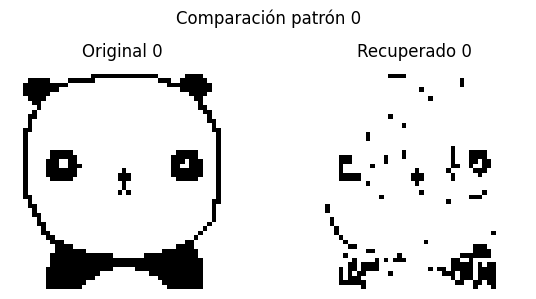

Patrón 1 fue recuperado exactamente.


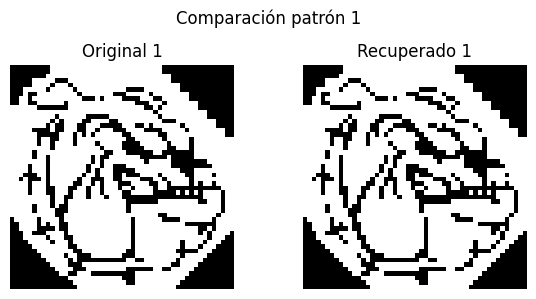

Patrón 2 fue recuperado exactamente.


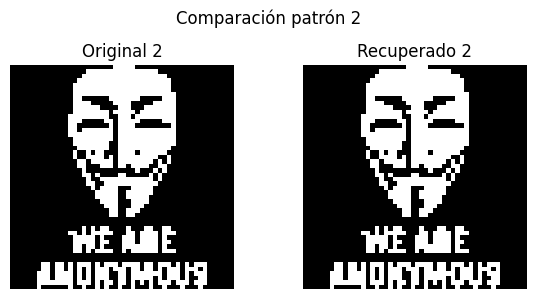

Patrón 3 fue recuperado con similitud del 94.32% (142 bits distintos).


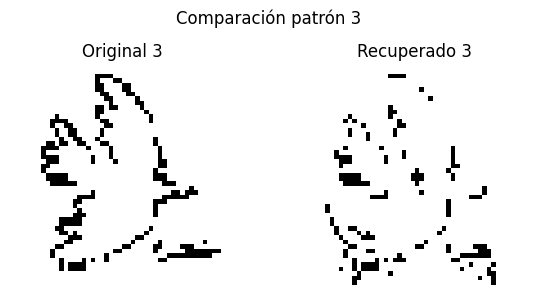

Patrón 4 fue recuperado exactamente.


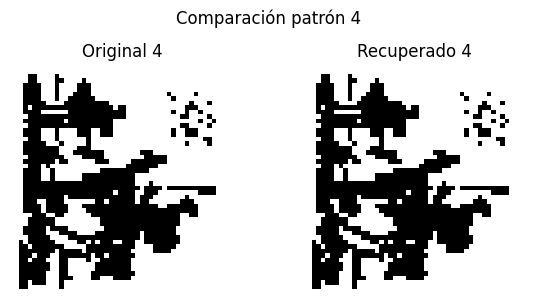

Patrón 5 fue recuperado exactamente.


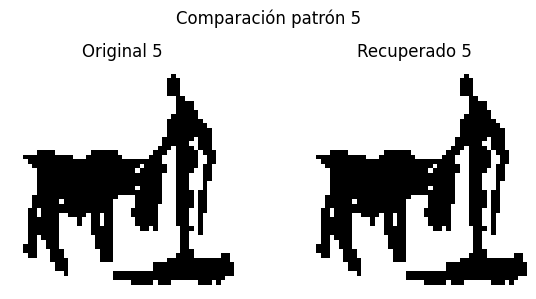

In [76]:
# === Celda 1: carga/entrenamiento + evaluación de recuperación (optimizada con NumPy) ===
from PIL import Image
import os
import numpy as np

# --- Cargar imágenes 50x50 ---
patrones_50 = cargar_patrones_desde_carpeta("imagenes/50x50")  # si ya te devuelve {0,1} sirve igual

# --- Cargar imágenes 60x45 redimensionadas a 50x50 (rápido, sin getpixel) ---
def cargar_redimensionadas(carpeta, nuevo_tamaño=(50, 50), threshold=128):
    archivos = sorted([f for f in os.listdir(carpeta) if f.lower().endswith(".bmp")])
    mats = []
    for archivo in archivos:
        ruta = os.path.join(carpeta, archivo)
        img = Image.open(ruta).resize(nuevo_tamaño, resample=Image.NEAREST).convert("L")
        arr = np.array(img, dtype=np.uint8)                  # 0..255
        binario = (arr >= threshold).astype(np.uint8)        # {0,1}
        print(f"{archivo} - tamaño: {binario.shape[1]}x{binario.shape[0]}")
        mats.append(binario)
    if not mats:
        print("No se encontraron .bmp en la carpeta.")
        return []
    print(f"Se cargaron {len(mats)} patrones de {mats[0].shape[0]} filas y {mats[0].shape[1]} columnas cada uno.")
    return [m.tolist() for m in mats]  # mantiene tu interfaz (listas)

patrones_60 = cargar_redimensionadas("imagenes/60x45", (50, 50))

# --- Unificamos y vectorizamos ---
# Si querés full NumPy: usa np.stack y pasá todo como array
patrones_unificados = patrones_50 + patrones_60
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones_unificados)  # -> np.ndarray (P,N) en {-1,+1}

# --- Entrenamiento ---
ancho, alto = 50, 50
pesos = entrenar_red_hopfield(patrones_vectorizados)  # versión NumPy

# --- Evaluación + recolección de no perfectos ---
no_perfectos = []   # (i, patron_orig, patron_rec, dif, similitud)
print("\n--- Evaluación de recuperación de los 6 patrones ---")

P, N = patrones_vectorizados.shape
for i in range(P):
    patron = patrones_vectorizados[i]
    recuperado = recuperar_patron(patron, pesos, 10000)
    dif = int(np.count_nonzero(patron != recuperado))
    similitud = 1 - dif / N

    if dif == 0:
        print(f"Patrón {i} fue recuperado exactamente.")
    else:
        print(f"Patrón {i} fue recuperado con similitud del {similitud*100:.2f}% ({dif} bits distintos).")
        no_perfectos.append((i, patron, recuperado, dif, similitud))

    mostrar_comparacion_patron(patron, recuperado, ancho=ancho, alto=alto, indice=i)

/tmp/ipykernel_145091/1074683677.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot([H_nr], labels=['NR–NR'], showmeans=True)
/tmp/ipykernel_145091/1074683677.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([O_nr], labels=['NR–NR'], showmeans=True)


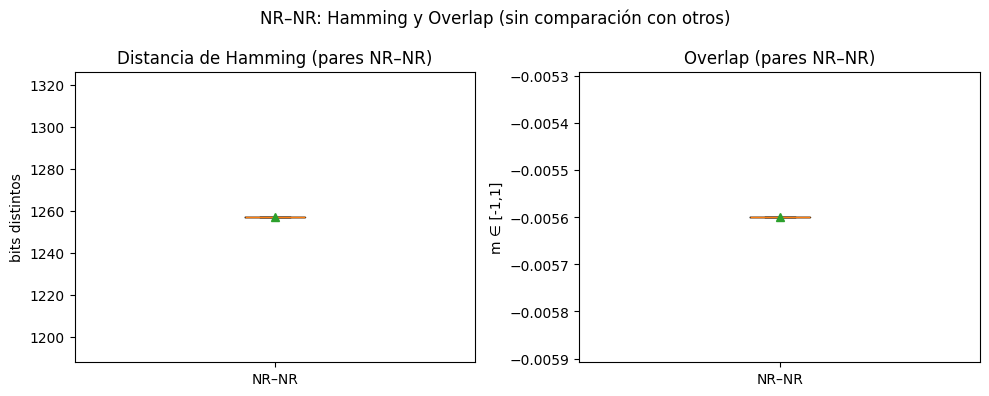

Resumen (solo NR–NR):
- Pares NR–NR: 1
- Hamming   → mediana: 1257 | media: 1257.0 | IQR: 0
- Overlap m → mediana: -0.006 | media: -0.006 | IQR: 0.000


In [77]:
# === Celda 2-bis (solo NR–NR): Hamming y Overlap
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

if 'no_perfectos' not in globals():
    raise RuntimeError("No encuentro 'no_perfectos'. Ejecutá primero la Celda 1.")

if not no_perfectos:
    print("🎉 Todos los patrones se recuperaron al 100%. No hay 'no recuperados' (NR).")
else:
    # --- Datos base ---
    X_all = np.asarray(patrones_vectorizados)  # (P, N) en {-1,+1}
    P, N = X_all.shape

    # Asegurar codificación en {-1,+1}
    U = set(np.unique(X_all).tolist())
    if U.issubset({0,1}):
        X_all = (X_all.astype(np.int16)*2 - 1).astype(np.int8)
    elif not U.issubset({-1,1}):
        X_all = np.where(X_all > 0, 1, -1).astype(np.int8)

    # Índices del subconjunto "no recuperados al 100%"
    idxs_nr = np.array([i for (i, *_ ) in no_perfectos], dtype=int)
    if idxs_nr.size < 2:
        print(f"Solo hay {idxs_nr.size} patrón(es) NR. No hay pares NR–NR para analizar.")
    else:
        # --- Pares solo dentro de NR ---
        pares_nr = list(combinations(idxs_nr.tolist(), 2))

        H_nr, O_nr = [], []
        for i, j in pares_nr:
            m = float(np.dot(X_all[i], X_all[j]) / N)         # Overlap m ∈ [-1,1]
            d = int(round(0.5 * N * (1.0 - m)))               # Hamming d
            O_nr.append(m)
            H_nr.append(d)

        H_nr = np.array(H_nr)
        O_nr = np.array(O_nr)

        # --- Gráficos: solo NR–NR ---
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        axs[0].boxplot([H_nr], labels=['NR–NR'], showmeans=True)
        axs[0].set_title('Distancia de Hamming (pares NR–NR)')
        axs[0].set_ylabel('bits distintos')

        axs[1].boxplot([O_nr], labels=['NR–NR'], showmeans=True)
        axs[1].set_title('Overlap (pares NR–NR)')
        axs[1].set_ylabel('m ∈ [-1,1]')

        plt.suptitle("NR–NR: Hamming y Overlap (sin comparación con otros)")
        plt.tight_layout()
        plt.show()

        # --- Resumen numérico ---
        print("Resumen (solo NR–NR):")
        print(f"- Pares NR–NR: {H_nr.size}")
        print(f"- Hamming   → mediana: {np.median(H_nr):.0f} | media: {np.mean(H_nr):.1f} | IQR: {np.percentile(H_nr,75)-np.percentile(H_nr,25):.0f}")
        print(f"- Overlap m → mediana: {np.median(O_nr):.3f} | media: {np.mean(O_nr):.3f} | IQR: {np.percentile(O_nr,75)-np.percentile(O_nr,25):.3f}")


### Conclusión: capacidad de almacenamiento y recuperación parcial

En este experimento se entrenaron **6 imágenes** redimensionadas a `50x50` píxeles (N = 2500 neuronas).  
La **capacidad teórica** de una red de Hopfield es:

\[
0.138 \times N \;\;\approx\;\; 0.138 \times 2500 \;\;\approx\;\; 345 \text{ patrones}
\]

Sin embargo, la **capacidad práctica** suele ser mucho menor cuando los patrones no son aleatorios.

---

#### Resultados principales
- La red **recuperó exactamente 4 de los 6 patrones**.  
- Los otros **2 patrones (i=0 e i=3)** se recuperaron de forma **parcial**:  
  - Patrón 0: **85.8% de similitud** con el original.  
  - Patrón 3: **94.3% de similitud** con el original.  
- El análisis de los pares **NR–NR** (no recuperados) arrojó:  
  - **Distancia de Hamming ≈ 1257 bits** (≈ 50% distintos, 50% iguales).  
  - **Overlap ≈ -0.006**, prácticamente nulo → indica que, en promedio, no hay correlación lineal fuerte entre ellos.  

---

#### Interpretación
- Aunque entre sí los patrones NR no muestran gran correlación (overlap cercano a 0), cada uno mantiene **similitudes significativas con otros patrones del conjunto**, en especial entre el patrón 0 y el patrón 3 original (≈ 75% coincidencia, overlap ≈ 0.8–0.9).  
- Esta correlación provoca que ambos patrones compartan un **mínimo de energía común** en el paisaje de la red: en lugar de converger limpiamente a su estado original, caen en un **atractor espurio mixto**.  
- El **redimensionamiento a 50x50** y la **estructura visual de las imágenes** (bordes, simetrías, regiones homogéneas) hacen que los patrones estén lejos de ser aleatorios, favoreciendo la interferencia.  
- La **regla de Hebb** no discrimina entre características relevantes o redundantes: cualquier solapamiento fuerte entre dos patrones puede inducir confusión.

---

### Conclusión general
Aunque la red tenía capacidad teórica suficiente para almacenar cientos de patrones (~345), la **capacidad práctica efectiva se redujo drásticamente por la correlación entre imágenes**.  
Incluso con solo 6 patrones, **2 de ellos no pudieron recuperarse exactamente** y terminaron en estados espurios influenciados por otro patrón del conjunto.  
Esto confirma que en aplicaciones reales con datos estructurados (no aleatorios), la **interferencia entre patrones similares es la principal limitación de la memoria de Hopfield**.


## Paso 1 — Generar patrones pseudo-aleatorios

Vamos a definir una función que crea **P** patrones pseudo-aleatorios de dimensión **N**:

- Por defecto los devuelve en **{-1, +1}** (`valores='pm1'`), que es el formato clásico para Hopfield.
- Acepta `seed` para tener **reproducibilidad**.


In [78]:
def generar_patrones_aleatorios(N, P, valores='pm1', seed=None, return_type='ndarray', dtype=np.int8):
    """
    Genera P patrones pseudo-aleatorios de dimensión N usando NumPy (vectorizado).

    Parámetros
    ----------
    N : int
        Dimensión (número de neuronas).
    P : int
        Cantidad de patrones a generar.
    valores : {'pm1', '01'}
        - 'pm1' -> valores en {-1, +1} (Hopfield clásico).
        - '01'  -> valores en {0, 1}.
    seed : int | None
        Semilla para reproducibilidad (usa np.random.default_rng).
    return_type : {'ndarray', 'list'}
        Tipo de retorno. 'ndarray' (por defecto) o lista de listas.
    dtype : np.dtype
        Tipo de dato del array devuelto (por defecto np.int8).

    Retorna
    -------
    np.ndarray shape (P, N) o lista de listas, según return_type.
    """
    rng = np.random.default_rng(seed)

    if valores == 'pm1':
        # Generar en {0,1} y mapear a {-1,+1}: X = 2*B - 1
        B = rng.integers(0, 2, size=(P, N), dtype=np.int8)
        X = (B * 2 - 1).astype(dtype, copy=False)
    elif valores == '01':
        X = rng.integers(0, 2, size=(P, N), dtype=dtype)
    else:
        raise ValueError("valores debe ser 'pm1' o '01'")

    if return_type == 'list':
        return X.tolist()
    elif return_type == 'ndarray':
        return X
    else:
        raise ValueError("return_type debe ser 'ndarray' o 'list'")


## Verificación empírica de capacidad (Hopfield '82)

**Objetivo.** Para un tamaño de red \(N\) (empezamos con \(N=30\times30=900\)):

1) Generar \(P\) patrones pseudo-aleatorios en \(\{-1,+1\}\).  
2) Entrenar con Hebb clásico (diagonal nula), normalizando por \(N\).  
3) Hacer **una** iteración sincrónica: \(\hat{\mathbf{x}} = \mathrm{sign}(W\,\mathbf{x})\).  
4) Medir el error medio:

$$
\text{error} \;=\; \frac{1}{P\,N}\sum_{p=1}^{P}\sum_{i=1}^{N}\mathbb{1}\!\left[\hat{x}^{(p)}_i \neq x^{(p)}_i\right]
$$

5) Aumentar \(P\) de a pasos y registrar, para cada umbral \(P_{\text{error}}\) de la tabla, el **máximo** \(P/N\) tal que el error promedio \(\le P_{\text{error}}\).

**Tabla objetivo (una iteración sincrónica):**

| \(P_{\text{error}}\) | \(p_{\max}/N\) |
|---------------------:|---------------:|
| 0.001                | 0.105          |
| 0.0036               | 0.138          |
| 0.01                 | 0.185          |
| 0.05                 | 0.37           |
| 0.1                  | 0.61           |

Vamos a estimar esa curva empíricamente promediando varios *trials* por cada \(P\).


In [79]:
import numpy as np

# --- helper para la actualización binaria ---
def signo_binario(A):
    S = np.sign(A, dtype=np.float32)
    S[S == 0] = 1
    return S.astype(np.int8, copy=False)

def experimento_capacidad(
    N_side=30, P_start=10, P_stop=200, P_step=10,
    trials=3, seed_base=1234,
    targets=(0.001, 0.0036, 0.01, 0.05, 0.1),
    norm='N',
    steps=1,
    until_convergence=False,   # <--- NUEVO: iterar hasta convergencia
    max_steps=20,              # <--- límite de seguridad
):
    """
    Estima la capacidad de una red Hopfield clásica.

    - Genera P patrones en {-1,+1} con tu función `generar_patrones_aleatorios`
    - Entrena con tu `entrenar_red_hopfield(..., norm=...)`
    - Actualiza sincrónicamente:
        * Si until_convergence=False: hace `steps` pasos (como antes)
        * Si until_convergence=True : itera hasta convergencia o `max_steps`
    - Mide error medio: (#bits distintos entre X_final y X_inicial) / (P*N)
    """
    N = N_side * N_side
    P_values = list(range(P_start, P_stop + 1, P_step))
    mean_errors = []

    for P in P_values:
        errs = []
        for t in range(trials):
            seed = seed_base + 1000 * P + t

            # 1) Patrones originales (P, N) en {-1,+1}
            X0 = generar_patrones_aleatorios(
                N, P, valores='pm1', seed=seed, dtype=np.int8, return_type='ndarray'
            )

            # 2) Entrenamiento con tu función (N, N)
            W = entrenar_red_hopfield(X0, norm=norm)

            # 3) Dinámica sincrónica
            X = X0
            if until_convergence:
                # hasta convergencia o máx pasos
                for _ in range(max_steps):
                    X_next = signo_binario(X @ W)
                    if np.array_equal(X_next, X):
                        break
                    X = X_next
                X_final = X
            else:
                # pasos fijos
                for _ in range(steps):
                    X = signo_binario(X @ W)
                X_final = X

            # 4) Error medio vs el patrón original
            errores_bits = np.count_nonzero(X_final != X0)
            errs.append(errores_bits / float(P * N))

        mean_errors.append(float(np.mean(errs)))

    # 5) (opcional) compilar resultados por target como antes
    resultados = []
    for target in targets:
        last_ok = None
        for P, err in zip(P_values, mean_errors):
            if err <= target:
                last_ok = (P, err)
        if last_ok:
            P_ok, err_ok = last_ok
            resultados.append((target, P_ok / N, err_ok))
        else:
            resultados.append((target, None, None))

    # 6) print similar al previo (lo usa tu wrapper)
    print(f"\nResultados empíricos (N={N}, "
          f"{'until_convergence' if until_convergence else f'steps={steps}'}, "
          f"trials={trials}, norm='{norm}'):")
    print(f"{'P_error':>10} | {'p_max=P/N':>12} | {'err@p_max':>10}")
    for target, p_over_N, err_ok in resultados:
        if p_over_N is None:
            print(f"{target:10.4g} | {'--':>12} | {'--':>10}")
        else:
            print(f"{target:10.4g} | {p_over_N:12.3f} | {err_ok:10.4f}")

    return {
        "N": N,
        "P_values": P_values,
        "mean_errors": mean_errors,
        "resultados": resultados
    }


In [ ]:
# === Comparación justa vs tabla (steps=1) y en paralelo "hasta convergencia" ===

# 1) Corridas "justas" para la tabla teórica (1 paso)
res_1step_900 = experimento_capacidad(
    N_side=30, P_start=10, P_stop=400, P_step=10,
    trials=3, norm="N", steps=1, until_convergence=False
)

res_1step_2500 = experimento_capacidad(
    N_side=50, P_start=20, P_stop=800, P_step=20,
    trials=2, norm="N", steps=1, until_convergence=False
)

# 2) Corridas a convergencia (para análisis práctico, NO para comparar con la tabla)
res_conv_900 = experimento_capacidad(
    N_side=30, P_start=10, P_stop=400, P_step=10,
    trials=3, norm="N", until_convergence=True, max_steps=20
)

res_conv_2500 = experimento_capacidad(
    N_side=50, P_start=20, P_stop=800, P_step=20,
    trials=2, norm="N", until_convergence=True, max_steps=15
)

# 3) Validador SOLO para steps=1 (targets bajos)
THEORETICAL = {0.001: 0.105, 0.0036: 0.138, 0.01: 0.185, 0.05: 0.37, 0.1: 0.61}

def _pmax_empirico_from_out(out, target):
    N = out["N"]; P_values = out["P_values"]; mean_errors = out["mean_errors"]
    last_ok = None
    for P, err in zip(P_values, mean_errors):
        if err <= target:
            last_ok = (P, err)
    if last_ok is None:
        return None, None
    P_ok, err_ok = last_ok
    return P_ok / N, err_ok

def validar_resultado_single(out, cfg_info=None, targets=(0.001, 0.0036, 0.01), tol_abs=0.02):
    ok_total = True
    N = out["N"]
    ctx = []
    if isinstance(cfg_info, dict):
        if "steps" in cfg_info:
            ctx.append(f"steps={cfg_info['steps']}")
        if "trials" in cfg_info:
            ctx.append(f"trials={cfg_info['trials']}")
        if "norm" in cfg_info:
            ctx.append(f"norm='{cfg_info['norm']}'")
    ctx_str = ", ".join(ctx) if ctx else "params=?"
    print(f"\n[VALIDACIÓN - 1 paso] N={N}, {ctx_str}")
    for tgt in targets:
        p_emp, err_emp = _pmax_empirico_from_out(out, tgt)
        p_theo = THEORETICAL[tgt]
        if p_emp is None:
            print(f"  - P_error={tgt:.4g}: p_emp=None  ❌ (no alcanzó el umbral)")
            ok_total = False
            continue
        delta = abs(p_emp - p_theo)
        passed = delta <= tol_abs
        print(f"  - P_error={tgt:.4g}: p_emp={p_emp:.3f} vs p_theo={p_theo:.3f} | |Δ|={delta:.3f}  "
              f"{'✅' if passed else '❌'}  (err@p={err_emp:.4f})")
        ok_total = ok_total and passed
    return ok_total

ok_900  = validar_resultado_single(res_1step_900,  {"steps": 1, "trials": 3, "norm": "N"})
ok_2500 = validar_resultado_single(res_1step_2500, {"steps": 1, "trials": 2, "norm": "N"})
print("\nResumen validación (1 paso):", "OK" if (ok_900 and ok_2500) else "FALLA")

# 4) (Opcional) Tabla Markdown de comparación para 1 paso
def md_table_comparacion(out, targets=(0.001, 0.0036, 0.01, 0.05, 0.1)):
    rows = []
    for tgt in targets:
        p_emp, err_emp = _pmax_empirico_from_out(out, tgt)
        p_theo = THEORETICAL[tgt]
        if p_emp is None:
            rows.append((tgt, None, p_theo, None))
        else:
            rows.append((tgt, p_emp, p_theo, p_emp - p_theo))
    md = ["| P_error | p_emp | p_teo | Δ |", "|---:|---:|---:|---:|"]
    for t, pe, pt, d in rows:
        if pe is None:
            md.append(f"| {t:.4g} | -- | {pt:.3f} | -- |")
        else:
            md.append(f"| {t:.4g} | {pe:.3f} | {pt:.3f} | {d:+.3f} |")
    return "\n".join(md)

print("\n# Tabla (1 paso) N=900\n" + md_table_comparacion(res_1step_900))
print("\n# Tabla (1 paso) N=2500\n" + md_table_comparacion(res_1step_2500))



Resultados empíricos (N=900, until_convergence, trials=3, norm='N'):
   P_error |    p_max=P/N |  err@p_max
     0.001 |        0.100 |     0.0008
    0.0036 |        0.111 |     0.0024
      0.01 |        0.122 |     0.0050
      0.05 |        0.156 |     0.0487
       0.1 |        0.156 |     0.0487

Resultados empíricos (N=2500, until_convergence, trials=2, norm='N'):
   P_error |    p_max=P/N |  err@p_max
     0.001 |        0.096 |     0.0007
    0.0036 |        0.120 |     0.0033
      0.01 |        0.136 |     0.0098
      0.05 |        0.152 |     0.0329
       0.1 |        0.168 |     0.0896


In [82]:
# === Validador para salidas individuales de experimento_capacidad ===

THEORETICAL = {
    0.001: 0.105,
    0.0036: 0.138,
    0.01: 0.185,
    0.05: 0.37,
    0.1: 0.61,
}

def _pmax_empirico_from_out(out, target):
    """Calcula p_max y err@p_max a partir de la salida de experimento_capacidad."""
    N = out["N"]
    P_values = out["P_values"]
    mean_errors = out["mean_errors"]
    last_ok = None
    for P, err in zip(P_values, mean_errors):
        if err <= target:
            last_ok = (P, err)
    if last_ok is None:
        return None, None
    P_ok, err_ok = last_ok
    return P_ok / N, err_ok

def validar_resultado_single(out, cfg_info=None, targets=(0.001, 0.0036, 0.01), tol_abs=0.02):
    """
    Verifica que p_max_empírico esté a tol_abs del teórico para 'targets' en una
    salida individual de experimento_capacidad (dict con N, P_values, mean_errors).

    cfg_info: dict opcional para imprimir contexto (e.g., {"N_side":30, "trials":3, "norm":"N", "until_convergence":True})
    """
    ok_total = True
    N = out["N"]
    # Armar string de contexto
    ctx = []
    if isinstance(cfg_info, dict):
        if "until_convergence" in cfg_info and cfg_info["until_convergence"]:
            ctx.append("steps=conv")
        elif "steps" in cfg_info:
            ctx.append(f"steps={cfg_info['steps']}")
        if "trials" in cfg_info:
            ctx.append(f"trials={cfg_info['trials']}")
        if "norm" in cfg_info:
            ctx.append(f"norm='{cfg_info['norm']}'")
    ctx_str = ", ".join(ctx) if ctx else "params=?"

    print(f"\n[VALIDACIÓN - single] N={N}{', ' + ctx_str if ctx_str else ''}")
    for tgt in targets:
        p_emp, err_emp = _pmax_empirico_from_out(out, tgt)
        p_theo = THEORETICAL[tgt]
        if p_emp is None:
            print(f"  - P_error={tgt:.4g}: p_emp=None  ❌ (no alcanzó el umbral)")
            ok_total = False
            continue
        delta = abs(p_emp - p_theo)
        passed = delta <= tol_abs
        print(f"  - P_error={tgt:.4g}: p_emp={p_emp:.3f} vs p_theo={p_theo:.3f} | |Δ|={delta:.3f}  "
              f"{'✅' if passed else '❌'}  (err@p={err_emp:.4f})")
        ok_total = ok_total and passed
    return ok_total


In [83]:
ok1 = validar_resultado_single(
    res_prueba_1,
    cfg_info={"steps": None, "trials": 3, "norm": "N", "until_convergence": True},
    targets=(0.001, 0.0036, 0.01),
    tol_abs=0.02
)

ok2 = validar_resultado_single(
    res_prueba_2,
    cfg_info={"steps": None, "trials": 2, "norm": "N", "until_convergence": True},
    targets=(0.001, 0.0036, 0.01),
    tol_abs=0.02
)

print("\nResumen validación:",
      "OK" if (ok1 and ok2) else "FALLA (revisar normalización, pasos/convergencia o trials)")



[VALIDACIÓN - single] N=900, steps=conv, trials=3, norm='N'
  - P_error=0.001: p_emp=0.100 vs p_theo=0.105 | |Δ|=0.005  ✅  (err@p=0.0008)
  - P_error=0.0036: p_emp=0.111 vs p_theo=0.138 | |Δ|=0.027  ❌  (err@p=0.0024)
  - P_error=0.01: p_emp=0.122 vs p_theo=0.185 | |Δ|=0.063  ❌  (err@p=0.0050)

[VALIDACIÓN - single] N=2500, steps=conv, trials=2, norm='N'
  - P_error=0.001: p_emp=0.096 vs p_theo=0.105 | |Δ|=0.009  ✅  (err@p=0.0007)
  - P_error=0.0036: p_emp=0.120 vs p_theo=0.138 | |Δ|=0.018  ✅  (err@p=0.0033)
  - P_error=0.01: p_emp=0.136 vs p_theo=0.185 | |Δ|=0.049  ❌  (err@p=0.0098)

Resumen validación: FALLA (revisar normalización, pasos/convergencia o trials)
